<a href="https://colab.research.google.com/github/sychun/colab/blob/master/h_nn_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# y를 찾는 것이 아니고 새로운 X에서 유사한 X'를 구함

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Input, Dense, Lambda, Layer
from keras.models import Model
from keras import backend as K
from keras import metrics
from keras.datasets import mnist

Using TensorFlow backend.


In [3]:
# !pip install tensorflow==2.1.0
# !pip install keras==2.3.1

In [4]:
import tensorflow
import keras
keras.__version__, tensorflow.__version__

('2.3.1', '2.1.0')

In [5]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 1s 0us/step


In [6]:
x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [7]:
image_size = x_train.shape[1]
original_dim = image_size * image_size
latent_dim = 2 # 784에서 2개로 줄이겠다
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0 # epsilon: noise

# 훈련 배열 전 처리
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

In [8]:
x_train.shape,  x_test.shape, type(x_train)

((60000, 784), (10000, 784), numpy.ndarray)

In [9]:
# 인코더 모듈
input_layer = Input(shape=(original_dim,))
intermediate_layer = Dense(intermediate_dim,
                           activation='relu',
                           name='Intermediate_layer')(input_layer)
z_mean = Dense(latent_dim,
               name='z_mean')(intermediate_layer)
z_log_var = Dense(latent_dim,
                  name='z_log_var')(intermediate_layer)


In [10]:
encoder_module = Model(input_layer, (z_mean, z_log_var))
encoder_module.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
Intermediate_layer (Dense)      (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            514         Intermediate_layer[0][0]         
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            514         Intermediate_layer[0][0]         
Total params: 201,988
Trainable params: 201,988
Non-trainable params: 0
____________________

In [11]:
# 샘플링 함수 정의
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), 
                              mean=0., 
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon


In [12]:
# keras.layers.Lambda: 함수를 이용해서 층을 만드는 객체
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

In [13]:
# 디코더 모듈
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [14]:
# 커스텀 가변 손실 레이어
class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean):
        # 손실 1: 원본과 복제본의 차이
        xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
        # 손실 2: 분포 추정의 정확도
        kl_loss = -0.5 * K.sum(1 + z_log_var
                               - K.square(z_mean)
                               - K.exp(z_log_var),
                               axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean)
        self.add_loss(loss, inputs=inputs)
        return x

In [15]:
y = CustomVariationalLayer()([input_layer, x_decoded_mean])

In [16]:
vae = Model(input_layer, y)
vae.compile(optimizer='rmsprop', loss=None)


/usr/local/lib/python3.6/dist-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


In [17]:
vae.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
Intermediate_layer (Dense)      (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            514         Intermediate_layer[0][0]         
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            514         Intermediate_layer[0][0]         
____________________________________________________________________________________________

In [18]:
# 모델 훈련
vae.fit(x_train,
        shuffle=True,
        #epochs=epochs,
        epochs=10,
        batch_size=100,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 5s 81us/step - loss: 190.3743 - val_loss: 172.2000
Epoch 2/10
60000/60000 [==============================] - 3s 57us/step - loss: 169.7454 - val_loss: 167.8998
Epoch 3/10
60000/60000 [==============================] - 3s 55us/step - loss: 166.3814 - val_loss: 165.5223
Epoch 4/10
60000/60000 [==============================] - 3s 55us/step - loss: 164.3412 - val_loss: 163.8284
Epoch 5/10
60000/60000 [==============================] - 3s 55us/step - loss: 162.9490 - val_loss: 162.6382
Epoch 6/10
60000/60000 [==============================] - 3s 55us/step - loss: 161.7894 - val_loss: 161.4235
Epoch 7/10
60000/60000 [==============================] - 3s 55us/step - loss: 160.7248 - val_loss: 160.4659
Epoch 8/10
60000/60000 [==============================] - 3s 55us/step - loss: 159.7590 - val_loss: 159.8957
Epoch 9/10
60000/60000 [==============================] - 3s 54us/step - loss:

In [19]:
# np.array(x_test_encoded).shape
# x_test_encoded[1]

In [20]:
# type(x_test_encoded), len(x_test_encoded)

In [21]:
# 잠재 공간 2차원 시각화
x_test_encoded = encoder_module.predict(x_test, batch_size=256)
#x_test_encoded = encoder_network.predict(x_test, batch_size=256)

print()

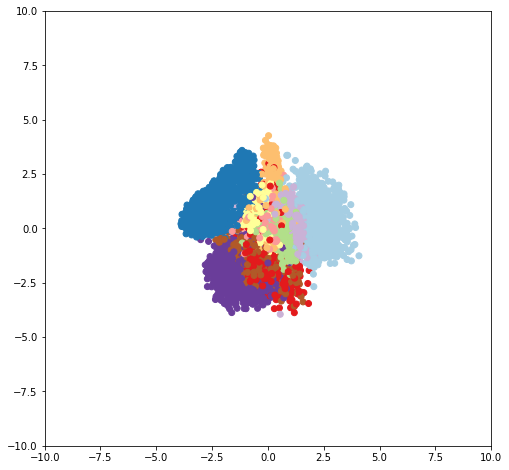

In [22]:
# filter = y_test ==7

plt.figure(figsize=(8, 8))
plt.xlim(-10,  10)
plt.ylim(-10, 10)
plt.scatter(x_test_encoded[0][:, 0], x_test_encoded[0][:, 1], c=y_test, cmap='Paired') # 평균의 분포
# plt.scatter(x_test_encoded[1][:, 0], x_test_encoded[1][:, 1], c=y_test, cmap='Paired') # 분산의 분포
# plt.colorbar()
plt.show()


In [23]:
# 학습한 분산으로부터 샘플을 생성하는 생성자 네트워크 구현
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [24]:
# grid_x = np.array([[3, 2], [2, 1]])
# grid_y = np.array([[1.5, 1.2], [[1.4, 1.3]]])

samples = sampling(x_test_encoded)
samples = samples.numpy()
samples

array([[-2.1883817 , -2.9700823 ],
       [ 0.6187633 , -0.1723154 ],
       [-2.4530582 ,  1.5620363 ],
       ...,
       [-0.97299814, -1.172175  ],
       [ 0.21335626,  2.5009127 ],
       [ 1.1914396 ,  0.56468964]], dtype=float32)

In [25]:
# samples[:, 1] = samples[:, 1] + 2 샘플 값의 변경이 미치는 영향을 보자

In [26]:
predicted_samples = generator.predict(samples[:2])
predicted_samples

array([[6.8937707e-30, 1.0511345e-29, 1.1449148e-30, ..., 1.6132287e-29,
        9.7183215e-31, 8.0071976e-31],
       [1.1072715e-10, 9.2828148e-11, 9.3644578e-11, ..., 9.8764927e-11,
        1.0685636e-10, 1.1922417e-10]], dtype=float32)

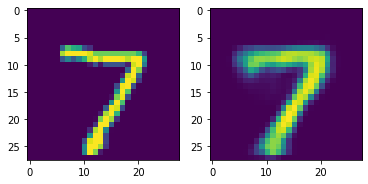

In [27]:
src_img = x_test[0].reshape(28, 28)
pred_img = predicted_samples[0].reshape(28, 28)
plt.subplot(1, 2, 1)
plt.imshow(src_img)
plt.subplot(1, 2, 2)
plt.imshow(pred_img)
plt.show()

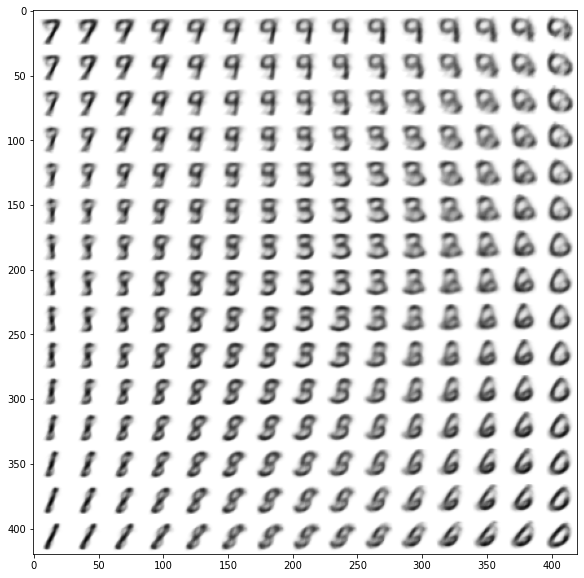

In [28]:
from scipy.stats import norm

# 숫자의 20 매니폴드 표시
n = 15  # 15 x 15 figure 크기
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# 단위 면적 공간에 선형적으로 위치한 좌표들은 가우시안 역 CDF(ppf)을 통해 변환되어 잠재 변수 z의 값을 생성한다. 
# 이전 잠재 공간이 가우시안 분포를 따르기 때문이다.
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

grid_x.shape, grid_y.shape, figure.shape

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) # (2, )
        x_decoded = generator.predict(z_sample) # (784, )
        digit = x_decoded[0].reshape(digit_size, digit_size) # (28, 28)
        figure[i * digit_size: (i + 1) * digit_size, 
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='binary')
plt.show()